In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

## Data preparation

In [2]:
def readData(path):
    with open(path, "r") as f:
        json_data = json.load(f)
        data = pd.DataFrame(json_data["data"])
    return data

In [3]:
path = "../../dataset/data_xyz/provinceData/上海.json"
path2 = "../../dataset/data_xyz/provinceData/广东.json"
path3 = "../../dataset/data_xyz/provinceData/西藏.json"

sh_data = readData(path)
gd_data = readData(path2)
xz_data = readData(path3)

In [4]:
xz_data

,confirmedCount,confirmedIncr,curedCount,curedIncr,currentConfirmedCount,currentConfirmedIncr,dateId,deadCount,deadIncr,highDangerCount,midDangerCount,suspectedCount,suspectedCountIncr
0,1,1,0,0,1,1,20200129,0,0,0,0,0,0
1,1,0,0,0,1,0,20200130,0,0,0,0,0,0
2,1,0,0,0,1,0,20200131,0,0,0,0,0,0
3,1,0,0,0,1,0,20200201,0,0,0,0,0,0
4,1,0,0,0,1,0,20200202,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,1,0,1,0,0,0,20220511,0,0,0,0,0,0
818,1,0,1,0,0,0,20220512,0,0,0,0,0,0
819,1,0,1,0,0,0,20220513,0,0,0,0,0,0
820,1,0,1,0,0,0,20220514,0,0,0,0,0,0


In [5]:
def show_plot(data, end_day, start_day=0):
    current_confirm = data.currentConfirmedCount.iloc[start_day:]
    plt.plot(current_confirm)
    plt.show()
    print("Date from %s to %s" % (data.loc[start_day, "dateId"], data.loc[end_day - 1, "dateId"]))

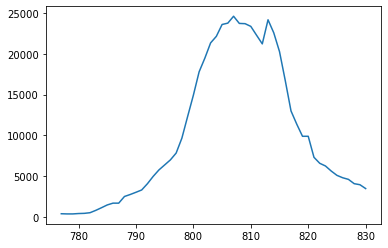

Date from 20220323 to 20220515


In [6]:
sh_start_day, sh_end = 777, sh_data.shape[0]
show_plot(sh_data, sh_end, sh_start_day)

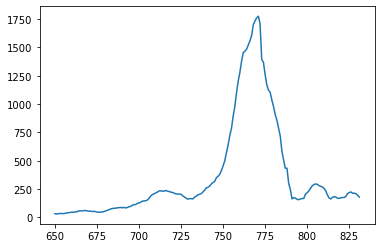

Date from 20211115 to 20220515


In [7]:
gd_start_day, gd_end = 650, gd_data.shape[0]
show_plot(gd_data, gd_end, gd_start_day)

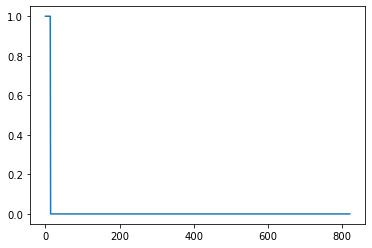

Date from 20200129 to 20220515


In [8]:
xz_start, xz_end = 0, xz_data.shape[0]
show_plot(xz_data, xz_end, xz_start)

## Predict

### SIR

#### SH

In [9]:
from model.SIR.SIR import SIR

In [10]:
def init_params(city, population_ceof, start_day=0, population_path="../../dataset/population7th.csv"):
    populations = pd.read_csv(population_path)
    # TODO:
    all_num = populations[populations.Province == city].iloc[0, 1] // population_ceof

    I0_num = sh_data.loc[start_day, "currentConfirmedCount"]
    r0_num = sh_data.loc[start_day, "deadCount"] + sh_data.loc[start_day, "curedCount"]
    S0_num = all_num - I0_num - r0_num

    S0 = S0_num / all_num
    I0 = I0_num / all_num
    r0 = r0_num / all_num
    return all_num, S0_num, I0_num, r0_num, S0, I0, r0

In [51]:
def eval(pred, test):
    diff = np.abs(pred - test)
    return np.sum(diff)/ diff.shape[0]

In [52]:
def show_predict(data, all_num, end_day, start_day, S0, I0, beta, gamma):
    sir = SIR(S0=S0, I0=I0, beta=beta, gamma=gamma)
    # sir = SIR(S0=S0,I0=I0,beta=1,gamma=0.60)

    pred = sir.predict(np.arange(0, end_day - start_day))

    pre_infected = pred[:, 1] * all_num
    gt_infected = data.loc[start_day:end_day - 1, "currentConfirmedCount"].reset_index(drop=True)
    plt.plot(pre_infected, '-g', label="predict")
    plt.plot(gt_infected, '-r', label="actual")
    plt.show()
    print("Average error:",eval(pre_infected, gt_infected))
    return sir, pred

In [53]:
pop = "../../dataset/population7th.csv"
pop_data = pd.read_csv(pop)
total_pop = pop_data.iloc[0, 1]
average_pop = total_pop / pop_data.shape[0]
pop_scale = 24 * 15
average_pop

40336534.97142857

In [54]:
sh = "上海"
all_sh, S0_num_sh, I0_num_sh, r0_num_sh, S0, I0, r0 = init_params(sh, 15, start_day=sh_start_day)
print(S0_num_sh, I0_num_sh, r0_num_sh)
print(S0, I0, r0)
average_pop / all_sh

1652965 371 4723
0.9969277329696953 0.00022375560821418297 0.002848511422090529


24.327563115322537

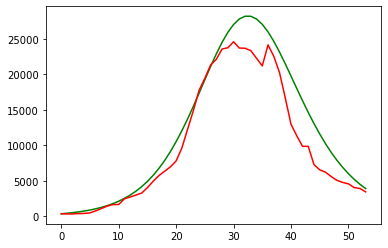

Average error: 2090.9723114421486


In [55]:
sh_sir, sh_pred = show_predict(sh_data, all_sh, sh_end, sh_start_day, S0, I0, 1, 0.8195);

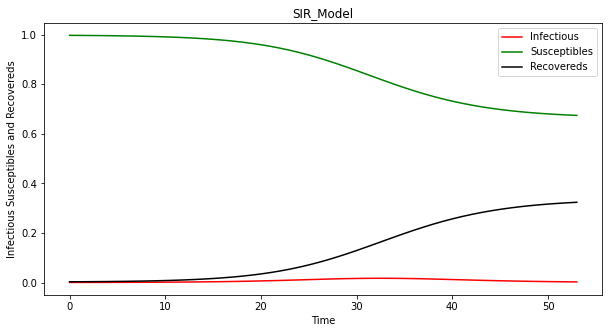

In [56]:
sh_sir.show(sh_pred, figsize=(10, 5))

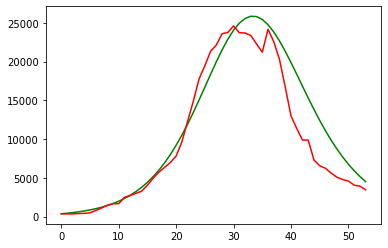

Average error: 1967.26888232632


In [57]:
show_predict(sh_data, all_sh, sh_end, sh_start_day, S0, I0, 1, 0.827);

#### GuangDong

In [58]:
gd = "广东"
gd_start_day = 700
all_gd, S0_num_gd, I0_num_gd, r0_num_gd, S0_gd, I0_gd, r0_gd = init_params(gd, 75, start_day=gd_start_day)
print(S0_num_gd, I0_num_gd, r0_num_gd)
print(S0_gd, I0_gd, r0_gd)

1676953 241 2972
0.9980876889545438 0.0001434382078913631 0.0017688728375648596


In [59]:
all_gd / all_sh

1.0133330599212693

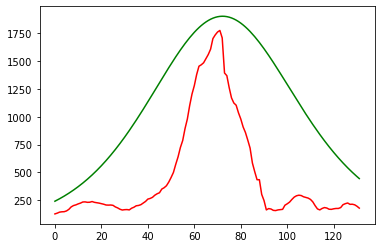

Average error: 646.9524475521307


In [60]:
sir_gd, gd_pred = show_predict(gd_data, all_gd, gd_end, gd_start_day, S0_gd, I0_gd, 1, 0.954)

In [45]:
offset = 70
new_S0, new_I0 = gd_pred[offset, 0], gd_pred[offset, 1]
new_S0, new_I0

(0.9563057661926985, 0.0011290416701527559)

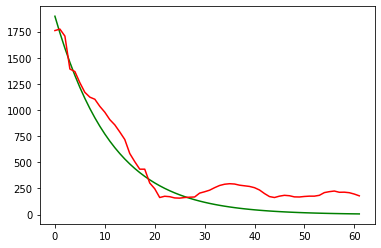

In [48]:
sir_gd2, gd_pred2 = show_predict(gd_data, all_gd, gd_end, gd_start_day + offset, new_S0, new_I0, 0.85, 0.9)

#### XZ

In [216]:
xz = "西藏"
xz_start = 0
all_num, S0_num, I0_num, r0_num, S0, I0, r0 = init_params(xz, 2000, start_day=xz_start)
print(S0_num, I0_num, r0_num)
print(S0, I0, r0)

1823 1 0
0.9994517543859649 0.0005482456140350877 0.0


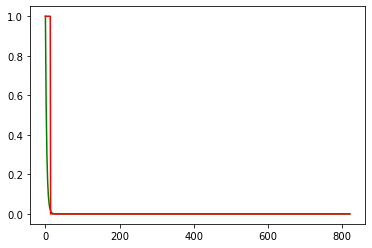

In [217]:
sir, pred = show_predict(xz_data, all_num, xz_end, xz_start, S0, I0, 0.5, 0.8)